# H-ASL: Hierarchical Axial Sphere Loss - Proof of Concept (PoC)

## 1. Objetivo do Experimento
Validar a eficácia de um **Nó Navegador (Routing Node)** na arquitetura H-ASL.
A hipótese central é que o problema massivo de classificação de faces ($1:N$) pode ser decomposto em decisões binárias hierárquicas ($Esquerda \times Direita$) sem perda de generalização.

Este experimento isola um único nó da árvore (o Nó Raiz) para responder a duas perguntas:
1. **Navegabilidade:** A rede consegue aprender a direcionar corretamente as classes conhecidas para os sub-grupos (clusters) definidos pelo *Spherical K-Means*?
2. **Rejeição (Open-Set):** A rede consegue utilizar a magnitude da *Axial Sphere Loss* para distinguir amostras de treino (Galeria) de amostras desconhecidas (Fundo/Gunther)?

## 2. Metodologia de Dados (Protocolo Gunther)
Seguindo a abordagem de *Open-Set Face Recognition* (Gunther et al., 2017), o dataset LFW é dividido em:
* **Known Set (Galeria):** Identidades com número de amostras $N \ge 3$. Estas serão usadas para construir a árvore e treinar a direção.
* **Unknown Set (Background):** Identidades com $N < 3$. Estas não participam da construção da árvore, mas são injetadas no treino como "negativos" (Label -1) para forçar a rede a aprender a rejeição (magnitude zero).

In [1]:
import sys
import pickle
import numpy as np
import torch
import matplotlib.pyplot as plt
from pathlib import Path
from collections import Counter
from sklearn.preprocessing import normalize
from torch.utils.data import DataLoader, TensorDataset

# Configuração de caminhos (Ajuste conforme seu ambiente)
import rootutils
root_path = rootutils.setup_root(".", indicator=".project-root", pythonpath=True)
src_path = Path(root_path) / "src"
if str(src_path) not in sys.path:
    sys.path.append(str(src_path))

# Imports dos seus módulos (agora limpos)
from models.losses.asl import AxialSpheresLoss
from models.neural_networks.node_network import NodeNetwork

# Configuração de Reprodução
SEED = 42
torch.manual_seed(SEED)
np.random.seed(SEED)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Ambiente configurado. Device: {device}")

Ambiente configurado. Device: cpu


In [2]:
EMBEDDINGS_FILE = root_path / "data" / "lfw_embeddings_processados.pkl"

In [3]:
def spherical_kmeans(X, n_clusters=2, max_iter=100, tol=1e-4):
    """
    Realiza o agrupamento esférico dos centróides das classes.
    Diferente do K-Means tradicional, este trabalha com similaridade de cosseno,
    ideal para embeddings faciais (ArcFace/InsightFace) que vivem em uma hiperesfera.
    """
    n_samples, n_features = X.shape
    
    # 1. Inicialização: Escolha aleatória de centróides iniciais
    indices = np.random.choice(n_samples, n_clusters, replace=False)
    centroids = X[indices].copy()
    
    for i in range(max_iter):
        old_centroids = centroids.copy()
        
        # 2. Atribuição: Dot Product em vetores normalizados = Similaridade de Cosseno
        sim_matrix = np.dot(X, centroids.T)
        labels = np.argmax(sim_matrix, axis=1)
        
        # 3. Atualização: Média dos vetores e re-normalização
        for k in range(n_clusters):
            members = X[labels == k]
            if len(members) > 0:
                new_center = np.mean(members, axis=0)
                # Projeção de volta à superfície da esfera unitária
                centroids[k] = new_center / np.linalg.norm(new_center)
            else:
                # Reinicialização de cluster vazio (raro, mas preventivo)
                centroids[k] = X[np.random.choice(n_samples)]
        
        # Critério de parada
        if np.sum((centroids - old_centroids)**2) < tol:
            break
            
    return labels, centroids

In [4]:
def prepare_node_data_strict(path_embeddings, min_samples=3, max_classes=None):
    """
    Prepara os dados para o treinamento de um nó específico (neste caso, Raiz).
    Aplica o protocolo Open-Set separando classes raras como 'Background'.
    """
    print(f"--- Carregando dados de {path_embeddings} ---")
    with open(path_embeddings, 'rb') as f:
        data = pickle.load(f)
    
    # Normalização L2 é pré-requisito mandatório para ASL e Spherical K-Means
    raw_embeddings = np.array(data['embeddings'])
    if raw_embeddings.ndim == 1: raw_embeddings = np.stack(raw_embeddings)
    embeddings = normalize(raw_embeddings, norm='l2', axis=1)
    names = np.array(data['nomes'])
    
    # --- PROTOCOLO DE SELEÇÃO (GUNTHER ET AL.) ---
    counts = Counter(names)
    unique_names = list(counts.keys())
    
    # Classes com poucas amostras (< min_samples) viram Background (Desconhecidos)
    bg_names = set([n for n in unique_names if counts[n] < min_samples])
    # Classes robustas (>= min_samples) formam a Galeria Conhecida
    known_names = [n for n in unique_names if counts[n] >= min_samples]
    
    if max_classes and len(known_names) > max_classes:
        known_names = known_names[:max_classes] # Limitador para testes rápidos
    
    known_set = set(known_names)
    print(f"Estatísticas do Dataset:")
    print(f" -> Total Identidades: {len(unique_names)}")
    print(f" -> Galeria (Known >= {min_samples} imgs): {len(known_set)} classes (Usadas na árvore)")
    print(f" -> Fundo (Unknown < {min_samples} imgs): {len(bg_names)} classes (Usadas para rejeição)")

    # Agrupar embeddings por classe para calcular centróides
    class_vectors = {n: [] for n in known_set}
    X_bg = [] # Lista para rejeição
    
    # Primeiro passo: Separar Known vs Unknown e agrupar Knowns
    for emb, name in zip(embeddings, names):
        if name in known_set:
            class_vectors[name].append(emb)
        elif name in bg_names:
            X_bg.append(emb)
            
    # --- CONSTRUÇÃO DA ÁRVORE (CLUSTERIZAÇÃO) ---
    # Calculamos 1 centróide por CLASSE CONHECIDA. 
    # A árvore divide IDENTIDADES, não imagens individuais.
    print("\nCalculando centróides e gerando árvore binária...")
    class_centroids_arr = []
    ordered_known_names = []
    
    for name in known_names:
        vecs = np.array(class_vectors[name])
        c = np.mean(vecs, axis=0)
        c = c / np.linalg.norm(c) # Re-normaliza o centróide
        class_centroids_arr.append(c)
        ordered_known_names.append(name)
        
    # Aplica Spherical K-Means nos centróides das classes
    labels_clustering, _ = spherical_kmeans(np.array(class_centroids_arr), n_clusters=2)
    
    # Cria mapa: Nome da Classe -> 0 (Esquerda) ou 1 (Direita)
    side_map = {name: lbl for name, lbl in zip(ordered_known_names, labels_clustering)}
    
    n_left = np.sum(labels_clustering == 0)
    n_right = np.sum(labels_clustering == 1)
    print(f" -> Divisão da Árvore: {n_left} Classes na Esquerda | {n_right} Classes na Direita")
    
    # --- MONTAGEM DO DATASET DE TREINO (TENSORS) ---
    final_X = []
    final_Y = [] # Labels: 0 (Esq), 1 (Dir), -1 (Unknown)
    
    # 1. Adiciona Amostras Conhecidas (Label 0 ou 1)
    for name in known_names:
        for emb in class_vectors[name]:
            final_X.append(emb)
            final_Y.append(side_map[name])
            
    # 2. Adiciona Amostras de Fundo (Label -1 para ASL empurrar para origem)
    # Importante: Balanceamento ou amostragem pode ser necessário aqui no futuro
    for emb in X_bg:
        final_X.append(emb)
        final_Y.append(-1)
        
    return np.array(final_X), np.array(final_Y), side_map


In [5]:
# --- CONFIGURAÇÃO EXPERIMENTAL ---

# 1. Instancia o Navegador (Routing Node)
# Input: 512 (Embedding) -> Output: 2 (Logits Esq/Dir)
model = NodeNetwork().to(device)

# 2. Instancia a Axial Sphere Loss (H-ASL)
# Parâmetros baseados no paper ASL original (alpha=10 garante margem angular robusta)
criterion = AxialSpheresLoss(
    num_classes=2, 
    alpha=10.0,    # Raio da esfera alvo
    beta=0.1,      # Peso da compactação intra-classe
    gamma=0.01,    # Peso da regularização de magnitude (rejeição)
    reduction='mean'
).to(device)

# 3. Otimizador
# Learning rate de 3e-4 é padrão para fine-tuning/adapters em Face Rec.
optimizer = torch.optim.Adam(model.parameters(), lr=0.0003, weight_decay=1e-5)

print("Modelo H-ASL inicializado:")
print(model)

Modelo H-ASL inicializado:
NodeNetwork(
  (layer1): Linear(in_features=512, out_features=256, bias=True)
  (layer2): Linear(in_features=256, out_features=256, bias=True)
  (layer3): Linear(in_features=256, out_features=2, bias=True)
  (activation): Tanh()
  (dropout): Dropout(p=0.2, inplace=False)
)


In [6]:

X_train_np, y_train_np, map_lados = prepare_node_data_strict(
    EMBEDDINGS_FILE, 
    min_samples=3, 
    max_classes=300 
)

# Converter para Tensores e DataLoader
tensor_x = torch.FloatTensor(X_train_np)
tensor_y = torch.LongTensor(y_train_np)

train_dataset = TensorDataset(tensor_x, tensor_y)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

print(f"\n--- Dataloader Pronto ---")
print(f"Total de Amostras de Treino: {len(train_dataset)}")
print(f"Shape do Input: {tensor_x.shape}")

--- Carregando dados de C:\Users\pedro\OneDrive\Documentos\git\h-asl-thesis\data\lfw_embeddings_processados.pkl ---
Estatísticas do Dataset:
 -> Total Identidades: 1680
 -> Galeria (Known >= 3 imgs): 300 classes (Usadas na árvore)
 -> Fundo (Unknown < 3 imgs): 805 classes (Usadas para rejeição)

Calculando centróides e gerando árvore binária...
 -> Divisão da Árvore: 160 Classes na Esquerda | 140 Classes na Direita

--- Dataloader Pronto ---
Total de Amostras de Treino: 5919
Shape do Input: torch.Size([5919, 512])


In [7]:
# --- LOOP DE TREINAMENTO ---
NUM_EPOCHS = 300
history = {'loss': [], 'acc_nav': [], 'mag_known': [], 'mag_unknown': []}

print(f"Iniciando treinamento por {NUM_EPOCHS} épocas...")
model.train()

for epoch in range(NUM_EPOCHS):
    epoch_loss = 0.0
    correct_nav = 0
    total_known = 0
    
    # Acumuladores para análise de magnitude
    mags_k = [] # Conhecidos
    mags_u = [] # Desconhecidos
    
    for embeddings, labels in train_loader:
        embeddings, labels = embeddings.to(device), labels.to(device)
        
        optimizer.zero_grad()
        
        # Forward Pass
        logits = model(embeddings)
        
        # Cálculo da Loss (H-ASL cuida da lógica de -1 internamente)
        loss = criterion(logits, labels)
        
        loss.backward()
        optimizer.step()
        
        epoch_loss += loss.item()
        
        # --- MÉTICAS DE MONITORAMENTO ---
        with torch.no_grad():
            # 1. Acurácia de Navegação (Apenas para Knowns: labels >= 0)
            mask_known = labels >= 0
            if mask_known.sum() > 0:
                preds = torch.argmax(logits[mask_known], dim=1)
                correct_nav += (preds == labels[mask_known]).sum().item()
                total_known += mask_known.sum().item()
                
                # Magnitude média dos Conhecidos
                mags_k.append(logits[mask_known].norm(p=2, dim=1).mean().item())
            
            # 2. Magnitude dos Desconhecidos (Labels < 0)
            mask_unknown = labels < 0
            if mask_unknown.sum() > 0:
                mags_u.append(logits[mask_unknown].norm(p=2, dim=1).mean().item())

    # Consolidação da Época
    avg_loss = epoch_loss / len(train_loader)
    acc = (correct_nav / total_known) * 100 if total_known > 0 else 0.0
    avg_mag_k = np.mean(mags_k) if mags_k else 0.0
    avg_mag_u = np.mean(mags_u) if mags_u else 0.0
    
    history['loss'].append(avg_loss)
    history['acc_nav'].append(acc)
    history['mag_known'].append(avg_mag_k)
    history['mag_unknown'].append(avg_mag_u)
    
    if (epoch + 1) % 10 == 0:
        print(f"Epoch [{epoch+1}/{NUM_EPOCHS}] | "
              f"Loss: {avg_loss:.4f} | "
              f"Nav. Acc: {acc:.1f}% | "
              f"Mag Known: {avg_mag_k:.2f} | "
              f"Mag Unknown: {avg_mag_u:.2f}")

print("Treinamento concluído.")

Iniciando treinamento por 300 épocas...
Epoch [10/300] | Loss: 0.3323 | Nav. Acc: 99.0% | Mag Known: 9.31 | Mag Unknown: 7.76
Epoch [20/300] | Loss: 0.2501 | Nav. Acc: 99.4% | Mag Known: 9.43 | Mag Unknown: 8.05
Epoch [30/300] | Loss: 0.1967 | Nav. Acc: 99.9% | Mag Known: 9.66 | Mag Unknown: 8.63
Epoch [40/300] | Loss: 0.1872 | Nav. Acc: 99.7% | Mag Known: 9.71 | Mag Unknown: 8.81
Epoch [50/300] | Loss: 0.1755 | Nav. Acc: 99.8% | Mag Known: 9.75 | Mag Unknown: 8.90
Epoch [60/300] | Loss: 0.1653 | Nav. Acc: 100.0% | Mag Known: 9.79 | Mag Unknown: 8.97
Epoch [70/300] | Loss: 0.1639 | Nav. Acc: 99.9% | Mag Known: 9.80 | Mag Unknown: 9.05
Epoch [80/300] | Loss: 0.1553 | Nav. Acc: 100.0% | Mag Known: 9.83 | Mag Unknown: 9.08
Epoch [90/300] | Loss: 0.1528 | Nav. Acc: 100.0% | Mag Known: 9.84 | Mag Unknown: 9.14
Epoch [100/300] | Loss: 0.1513 | Nav. Acc: 100.0% | Mag Known: 9.85 | Mag Unknown: 9.14
Epoch [110/300] | Loss: 0.1492 | Nav. Acc: 100.0% | Mag Known: 9.85 | Mag Unknown: 9.11
Epoch [

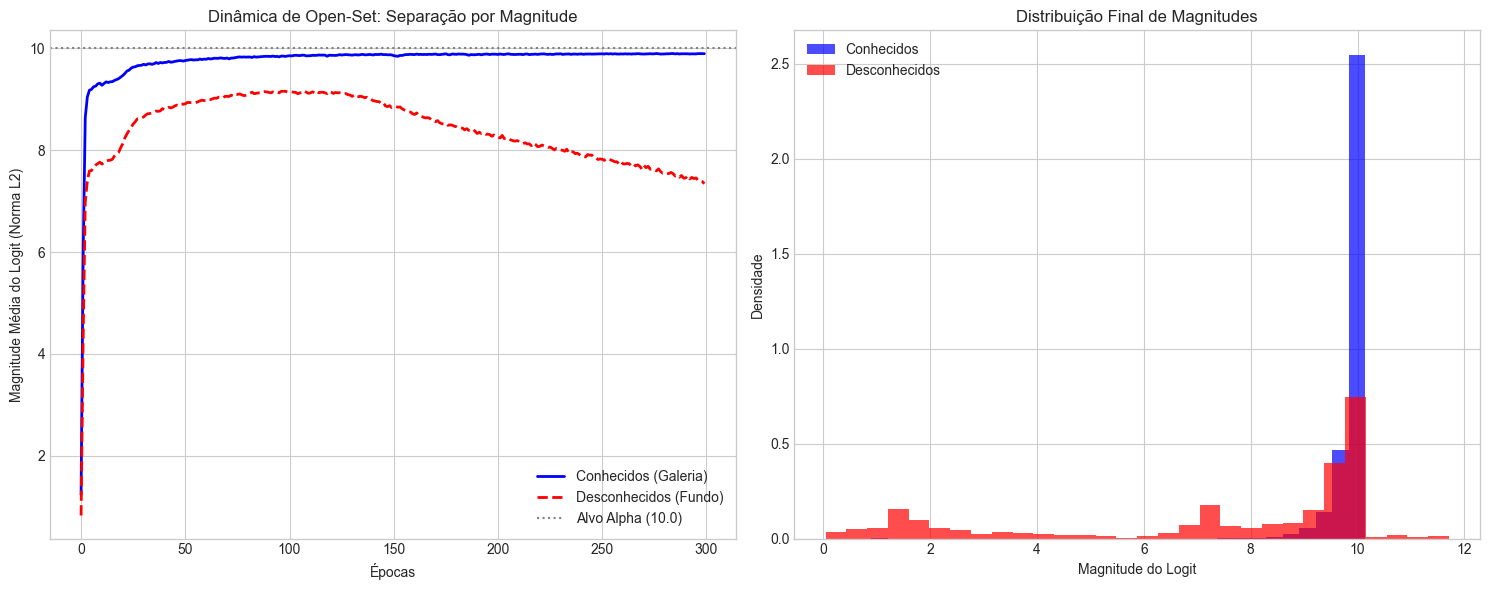


--- CONCLUSÃO DO EXPERIMENTO ---
Gap de Separação (Known - Unknown): 2.53
RESULTADO: SUCESSO. A rede criou uma margem de segurança clara para rejeição.


In [8]:
# --- ANÁLISE DE RESULTADOS (PROOF OF CONCEPT) ---

# Configuração visual
plt.style.use('seaborn-v0_8-whitegrid')
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Gráfico 1: Evolução da Magnitude (O "Pulo do Gato" da ASL)
# Mostra que a rede aprendeu a distinguir Known vs Unknown pela norma do vetor
ax1.plot(history['mag_known'], label='Conhecidos (Galeria)', color='blue', linewidth=2)
ax1.plot(history['mag_unknown'], label='Desconhecidos (Fundo)', color='red', linestyle='--', linewidth=2)
ax1.axhline(y=10.0, color='gray', linestyle=':', label='Alvo Alpha (10.0)')
ax1.set_title("Dinâmica de Open-Set: Separação por Magnitude")
ax1.set_xlabel("Épocas")
ax1.set_ylabel("Magnitude Média do Logit (Norma L2)")
ax1.legend()

# Gráfico 2: Distribuição Final das Magnitudes (Histograma)
# Roda inferência em todo o dataset para pegar o estado final
model.eval()
all_mags_k = []
all_mags_u = []

with torch.no_grad():
    full_logits = model(tensor_x.to(device))
    full_mags = full_logits.norm(p=2, dim=1).cpu().numpy()
    full_lbls = tensor_y.numpy()
    
    all_mags_k = full_mags[full_lbls >= 0]
    all_mags_u = full_mags[full_lbls < 0]

ax2.hist(all_mags_k, bins=30, alpha=0.7, color='blue', label='Conhecidos', density=True)
ax2.hist(all_mags_u, bins=30, alpha=0.7, color='red', label='Desconhecidos', density=True)
ax2.set_title("Distribuição Final de Magnitudes")
ax2.set_xlabel("Magnitude do Logit")
ax2.set_ylabel("Densidade")
ax2.legend()

plt.tight_layout()
plt.show()

# Conclusão Textual Automática
print("\n--- CONCLUSÃO DO EXPERIMENTO ---")
gap = np.mean(all_mags_k) - np.mean(all_mags_u)
print(f"Gap de Separação (Known - Unknown): {gap:.2f}")
if gap > 2.0:
    print("RESULTADO: SUCESSO. A rede criou uma margem de segurança clara para rejeição.")
else:
    print("RESULTADO: INCONCLUSIVO. As distribuições ainda estão muito próximas.")

Gerando inferência para análise visual...


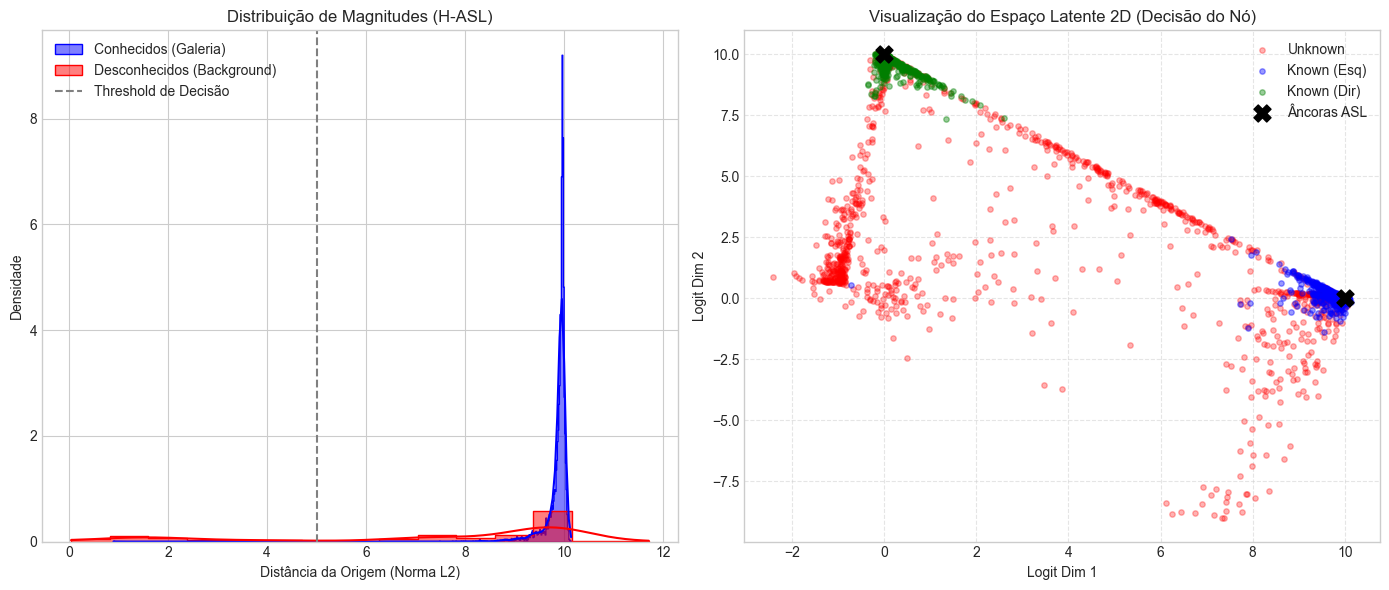


--- ESTATÍSTICAS FINAIS ---
Média Magnitude Conhecidos:   9.8570 (Ideal: próximo de 10.0)
Média Magnitude Desconhecidos:7.3227 (Ideal: próximo de 0.0)
Gap de Separação:             2.5343


In [9]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import torch

def analyze_magnitudes(model, loader, device):
    """
    Gera visualizações críticas para validar a H-ASL:
    1. Histograma de Magnitudes (Separação Open-Set)
    2. Scatter Plot 2D (Estrutura Axial e Navegação)
    """
    model.eval()
    
    # Listas para guardar as magnitudes e coordenadas
    mags_known = []
    mags_unknown = []
    
    logits_x = []
    logits_y = []
    plot_labels = [] # Labels para colorir o scatter
    
    print("Gerando inferência para análise visual...")
    
    with torch.no_grad():
        for batch_X, batch_y in loader:
            batch_X = batch_X.to(device)
            
            # Passar pela rede treinada
            logits = model(batch_X) # Saída 2D
            
            # Calcular magnitude (distância da origem)
            magnitudes = torch.norm(logits, p=2, dim=1).cpu().numpy()
            current_labels = batch_y.cpu().numpy()
            current_logits = logits.cpu().numpy()
            
            # Separar Conhecidos (>=0) de Desconhecidos (-1)
            for mag, label, logit in zip(magnitudes, current_labels, current_logits):
                if label >= 0:
                    mags_known.append(mag)
                    # Label 0 = Esquerda, Label 1 = Direita
                    side = "Esquerda" if label == 0 else "Direita"
                    plot_labels.append(f"Known ({side})") 
                else:
                    mags_unknown.append(mag)
                    plot_labels.append("Unknown/Background")
                
                # Guardar coordenadas para scatter plot
                logits_x.append(logit[0])
                logits_y.append(logit[1])

    # --- PLOTAGEM ---
    plt.figure(figsize=(14, 6))
    
    # --- PLOT 1: HISTOGRAMA DE MAGNITUDES (A PROVA DE FOGO) ---
    plt.subplot(1, 2, 1)
    sns.histplot(mags_known, color='blue', label='Conhecidos (Galeria)', kde=True, stat="density", element="step")
    # Verifica se existem desconhecidos antes de plotar para evitar erro do seaborn
    if mags_unknown:
        sns.histplot(mags_unknown, color='red', label='Desconhecidos (Background)', kde=True, stat="density", element="step")
    
    plt.title("Distribuição de Magnitudes (H-ASL)")
    plt.xlabel("Distância da Origem (Norma L2)")
    plt.ylabel("Densidade")
    # Linha de referência no meio do caminho (0 a 10)
    plt.axvline(x=5.0, color='gray', linestyle='--', label='Threshold de Decisão')
    plt.legend()
    
    # --- PLOT 2: ESPAÇO LATENTE 2D ---
    plt.subplot(1, 2, 2)
    
    lx = np.array(logits_x)
    ly = np.array(logits_y)
    lbls = np.array(plot_labels)
    
    # 1. Plot Unknowns (Vermelho, devem estar na origem)
    mask_unk = lbls == "Unknown/Background"
    if np.any(mask_unk):
        plt.scatter(lx[mask_unk], ly[mask_unk], c='red', alpha=0.3, s=15, label='Unknown')
    
    # 2. Plot Knowns Esquerda (Azul, devem estar no eixo X [10, 0])
    mask_left = lbls == "Known (Esquerda)"
    if np.any(mask_left):
        plt.scatter(lx[mask_left], ly[mask_left], c='blue', alpha=0.4, s=15, label='Known (Esq)')

    # 3. Plot Knowns Direita (Verde, devem estar no eixo Y [0, 10])
    mask_right = lbls == "Known (Direita)"
    if np.any(mask_right):
        plt.scatter(lx[mask_right], ly[mask_right], c='green', alpha=0.4, s=15, label='Known (Dir)')
    
    # Desenhar os Eixos Alvo da ASL (Alpha=10)
    # Eixo X [10, 0] e Eixo Y [0, 10]
    plt.scatter([10, 0], [0, 10], c='black', marker='X', s=150, label='Âncoras ASL', zorder=10)
    
    plt.title("Visualização do Espaço Latente 2D (Decisão do Nó)")
    plt.xlabel("Logit Dim 1")
    plt.ylabel("Logit Dim 2")
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.legend(loc='upper right')
    
    plt.tight_layout()
    plt.show()
    
    # Métricas Textuais
    mean_k = np.mean(mags_known) if mags_known else 0
    mean_u = np.mean(mags_unknown) if mags_unknown else 0
    print(f"\n--- ESTATÍSTICAS FINAIS ---")
    print(f"Média Magnitude Conhecidos:   {mean_k:.4f} (Ideal: próximo de 10.0)")
    print(f"Média Magnitude Desconhecidos:{mean_u:.4f} (Ideal: próximo de 0.0)")
    print(f"Gap de Separação:             {mean_k - mean_u:.4f}")

# RODAR ANÁLISE COM O MODELO TREINADO
analyze_magnitudes(model, train_loader, device)